# Práctica de ML con Python
### Estimación del precio del airbnb 

En este notebook haremos un análisis exploratorio básico de la base de datos de airbnb, para familiarizarnos con los datos y posteriormente aplicar técnicas de machine learning sobre ellos. 




Vamos a utilizar **DataFrames** de [Pandas](http://pandas.pydata.org/). Como es sabido, Pandas es un módulo de python de código abierto para el análisis de datos, que proporciona estructuras de datos fáciles de utilizar.

In [322]:
import pandas as pd               # Para manipulación de datos
import numpy as np                # Para operaciones numéricas
import matplotlib.pyplot as plt    # Para visualización de datos
from sklearn.model_selection import train_test_split  # Para dividir los datos
from sklearn.preprocessing import StandardScaler     # Para escalar características
from sklearn.model_selection import GridSearchCV    #Para ajuste de hiperparámetros
from sklearn.linear_model import Lasso                 # Modelo de Lasso
from sklearn.ensemble import BaggingRegressor    #Modelo de Baggin Regressor
from sklearn.tree import DecisionTreeRegressor   #Estimador base para BaggingRegressor
from sklearn.ensemble import RandomForestRegressor    # Modelo de Random Forest
from sklearn.metrics import mean_squared_error, r2_score  # Para evaluación del modelo
from sklearn.model_selection import KFold         # Para validación cruzada kFold
%matplotlib inline

## 1. Carga de datos y división train/test

Hay que tener mucho cuidado a la hora de realizar la división, para no cometer data leakage. Vamos a  mirar el dataset, eliminar todas aquellas columnas que sabemos que se pueden quitar (ids, URLs, etc) y a continuación dividiremos en train/test para evitar riesgos.

In [323]:
# Cargar el dataset
airbnb_data = pd.read_csv('airbnb-listings-extract.csv', delimiter=';')

# Mostrar las dimensiones del DataFrame
print(f"\nDimensiones del DataFrame: {airbnb_data.shape}")

# Mostrar las primeras filas y la información del DataFrame
airbnb_data.head(5).T



Dimensiones del DataFrame: (14780, 89)


,0,1,2,3,4
ID,11210388,17471131,17584891,5398030,18104606
Listing Url,https://www.airbnb.com/rooms/11210388,https://www.airbnb.com/rooms/17471131,https://www.airbnb.com/rooms/17584891,https://www.airbnb.com/rooms/5398030,https://www.airbnb.com/rooms/18104606
Scrape ID,20170306202425,20170407214050,20170407214050,20170407214050,20170407214050
Last Scraped,2017-03-07,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,The Loft-Full Bath-Deck w/View,"Claris I, Friendly Rentals","Style Terrace Red, Friendly Rentals",Picasso Suite 1.4 Paseo de Gracia,Smart City Centre Apartment II
...,...,...,...,...,...
Cancellation Policy,moderate,super_strict_30,super_strict_30,strict,flexible
Calculated host listings count,1.0,106.0,106.0,24.0,92.0
Reviews per Month,3.5,0.86,NaN,1.09,NaN
Geolocation,"30.3373609355,-97.8632766782","41.3896829422,2.17262543017","41.3930345489,2.16217327868","41.3969668101,2.1674178103","41.3886851936,2.15514963616"


In [324]:
print("\nInformación del DataFrame:")
print(airbnb_data.info())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              14780 non-null  int64  
 1   Listing Url                     14780 non-null  object 
 2   Scrape ID                       14780 non-null  int64  
 3   Last Scraped                    14780 non-null  object 
 4   Name                            14779 non-null  object 
 5   Summary                         14189 non-null  object 
 6   Space                           10888 non-null  object 
 7   Description                     14774 non-null  object 
 8   Experiences Offered             14780 non-null  object 
 9   Neighborhood Overview           9134 non-null   object 
 10  Notes                           5644 non-null   object 
 11  Transit                         9066 non-null   object 
 12  Acce

Primero, eliminaremos las columnas que no son relevantes para la predicción del precio. o que podrían causar data leakage.

In [325]:
# Definir las columnas a eliminar con sus justificaciones
columns_to_drop = {
    "Identificadores y URLs: No aportan información predictiva para el precio.": [
        'ID', 'Listing Url', 'Scrape ID', 'Host ID', 'Host URL', 
        'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 
        'Host Thumbnail Url', 'Host Picture Url'
    ],
    "Información temporal no relevante para la predicción": [
        'Last Scraped', 'Host Since', 'Calendar Updated', 
        'Calendar last Scraped', 'First Review', 'Last Review'
    ],
    "Texto largo y descripciones: Requieren procesamiento de lenguaje natural avanzado": [
        'Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 
        'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Host About'
    ],
    "Información del host no directamente relacionada con el precio": [
        'Host Name', 'Host Location', 'Host Response Time', 'Host Response Rate', 
        'Host Acceptance Rate', 'Host Neighbourhood', 'Host Listings Count', 
        'Host Total Listings Count', 'Host Verifications'
    ],
    "Información geográfica redundante o muy específica: Ya tenemos otras columnas que capturan la ubicación": [
        'Street', 'Smart Location', 'Geolocation'
    ],
    "Columnas con muy pocos datos o irrelevantes para el precio": [
        'Experiences Offered', 'Has Availability', 'License', 'Jurisdiction Names'
    ],
    "Métricas derivadas que podrían causar data leakage": [
        'Calculated host listings count', 'Reviews per Month'
    ],
    "Columna que requiere procesamiento adicional y podría contener información ya capturada": [
        'Features'
    ]
}

# Imprimir justificaciones y contar columnas
total_columns = 0
print("Justificación para la eliminación de columnas:")
for category, cols in columns_to_drop.items():
    print(f"\n{category} ({len(cols)} columnas):")
    for col in cols:
        print(f"  - {col}")
    total_columns += len(cols)

print(f"\nTotal de columnas a eliminar: {total_columns}")

# Crear una lista plana de todas las columnas a eliminar
columns_to_drop_flat = [col for cols in columns_to_drop.values() for col in cols]

Justificación para la eliminación de columnas:

Identificadores y URLs: No aportan información predictiva para el precio. (11 columnas):
  - ID
  - Listing Url
  - Scrape ID
  - Host ID
  - Host URL
  - Thumbnail Url
  - Medium Url
  - Picture Url
  - XL Picture Url
  - Host Thumbnail Url
  - Host Picture Url

Información temporal no relevante para la predicción (6 columnas):
  - Last Scraped
  - Host Since
  - Calendar Updated
  - Calendar last Scraped
  - First Review
  - Last Review

Texto largo y descripciones: Requieren procesamiento de lenguaje natural avanzado (11 columnas):
  - Name
  - Summary
  - Space
  - Description
  - Neighborhood Overview
  - Notes
  - Transit
  - Access
  - Interaction
  - House Rules
  - Host About

Información del host no directamente relacionada con el precio (9 columnas):
  - Host Name
  - Host Location
  - Host Response Time
  - Host Response Rate
  - Host Acceptance Rate
  - Host Neighbourhood
  - Host Listings Count
  - Host Total Listings Count


In [326]:
# Eliminar las columnas irrelevantes
airbnb_data_cleaned = airbnb_data.drop(columns=columns_to_drop_flat)

Dividiremos los datos en entrenamiento y prueba utilizando el método `train_test_split`  para obtener dos subconjuntos: train y test.

In [327]:
train, test = train_test_split(airbnb_data_cleaned, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('airbnb_data_cleaned_train.csv', sep=';', decimal='.', index=False)
test.to_csv('airbnb_data_cleaned_test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 42)
Dimensiones del dataset de test: (2956, 42)


# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él.

In [328]:
airbnb_data = pd.read_csv('airbnb_data_cleaned_train.csv', sep=';', decimal='.')
print(f'Dimensiones del dataset airbnb_data: {airbnb_data.shape}')
airbnb_data.head(5).T

Dimensiones del dataset airbnb_data: (11824, 42)


,0,1,2,3,4
Neighbourhood,Jerónimos,NaN,Carabanchel,NaN,Gaztambide
Neighbourhood Cleansed,Jerónimos,Sol,Vista Alegre,Embajadores,Gaztambide
Neighbourhood Group Cleansed,Retiro,Centro,Carabanchel,Centro,Chamberí
City,Madrid,Madrid,Madrid,Madrid,Madrid
State,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,28
Zipcode,28014,28012,28025,28012,28015
Market,Madrid,Madrid,Madrid,Madrid,Madrid
Country Code,ES,ES,ES,ES,ES
Country,Spain,Spain,Spain,Spain,Spain
Latitude,40.407732,40.415802,40.389048,40.412814,40.438631


## 2. Análisis exploratorio

Podemos analizar la estructura básica del dataset con las funciones de Pandas que ya conocemos: `describe`, `dtypes`, `shape`, etc.

In [329]:
airbnb_data.describe()

,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,Price,Weekly Price,Monthly Price,...,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value
count,11824.000000,11824.000000,11824.000000,11780.000000,11804.00000,11787.000000,474.000000,11809.000000,2881.000000,2869.000000,...,11824.000000,11824.000000,11824.000000,9163.000000,9143.000000,9148.000000,9136.000000,9147.000000,9133.000000,9132.000000
mean,40.491628,-3.776863,3.277486,1.285229,1.34429,2.049122,396.489451,73.712592,378.437348,1432.390728,...,39.803958,202.217185,22.664834,91.628179,9.410040,9.320726,9.623905,9.647863,9.534655,9.211345
std,4.701030,14.014695,2.093973,0.664691,0.90518,1.623489,671.125823,71.624844,194.751472,1236.992934,...,29.663314,128.006830,38.092338,9.137614,0.938013,1.004472,0.804050,0.765450,0.770421,0.963131
min,-37.851182,-123.124429,1.000000,0.000000,0.00000,1.000000,0.000000,9.000000,70.000000,250.000000,...,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,40.409758,-3.707538,2.000000,1.000000,1.00000,1.000000,0.000000,34.000000,220.000000,720.000000,...,11.000000,78.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
50%,40.419331,-3.700763,3.000000,1.000000,1.00000,2.000000,90.000000,55.000000,350.000000,1200.000000,...,38.000000,240.000000,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000
75%,40.430778,-3.683917,4.000000,1.000000,2.00000,2.000000,624.000000,87.000000,500.000000,1750.000000,...,65.000000,319.000000,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,55.966912,153.371427,16.000000,8.000000,10.00000,16.000000,6997.000000,969.000000,999.000000,25000.000000,...,90.000000,365.000000,356.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


# Analizaremos la información por localización, para ver la distribución de datos

Los valores sobre el número de propiedades por ciudad y porcentajes nos pueden ayudar a tomar decisiones.

In [330]:
# Contar el número de propiedades por ciudad
city_counts = airbnb_data['City'].value_counts()

# Mostrar el número de propiedades para todas las ciudades
print("Número de propiedades por ciudad:")
print(city_counts)

# Mostrar el número total de propiedades
total_properties = city_counts.sum()
print(f"\nNúmero total de propiedades: {total_properties}")

# Calcular el porcentaje de propiedades en Madrid
madrid_percentage = (city_counts['Madrid'] / total_properties) * 100
print(f"\nPorcentaje de propiedades en Madrid: {madrid_percentage:.2f}%")

# Mostrar las ciudades con más de 5 propiedades
print("\nCiudades con más de 20 propiedades:")
print(city_counts[city_counts >=20])


Número de propiedades por ciudad:
City
Madrid              10567
Barcelona             235
London                104
Paris                  85
Palma                  44
                    ...  
Berlín                  1
Mile End / Bow          1
Dorroughby              1
Templeogue              1
Aravaca (Madrid)        1
Name: count, Length: 222, dtype: int64

Número total de propiedades: 11820

Porcentaje de propiedades en Madrid: 89.40%

Ciudades con más de 20 propiedades:
City
Madrid         10567
Barcelona        235
London           104
Paris             85
Palma             44
马德里               43
Roma              33
Berlin            32
Alcúdia           31
Dublin            29
New York          27
Los Angeles       26
Brooklyn          22
Wien              20
Name: count, dtype: int64


Efectivamente **10567 propiedades en Madrid** representan el **89.40%**. Vamos a quedarnos con estos datos, teniendo en cuenta que las otras ciudades no tienen una cantidad representativa para realizar estimaciones.

In [331]:
airbnb_madrid = airbnb_data[airbnb_data['City'] == 'Madrid']
print(airbnb_madrid['City'].value_counts())

City
Madrid    10567
Name: count, dtype: int64


Vamos a separar las variables numéricas y categóricas

In [332]:
numeric_airbnb_madrid = airbnb_madrid.select_dtypes(include=[np.number])
categorical_airbnb_madrid = airbnb_madrid.select_dtypes(exclude=[np.number])

In [333]:
#  Análisis de valores nulos
null_percentages = (numeric_airbnb_madrid.isnull().sum() / len(numeric_airbnb_madrid)) * 100
print("\nPorcentaje de valores nulos:")
print(null_percentages[null_percentages > 0].sort_values(ascending=False))


Porcentaje de valores nulos:
Square Feet                    96.091606
Monthly Price                  74.704268
Weekly Price                   74.477146
Security Deposit               56.950885
Cleaning Fee                   40.550771
Review Scores Location         21.869973
Review Scores Value            21.860509
Review Scores Checkin          21.841582
Review Scores Accuracy         21.784802
Review Scores Communication    21.746948
Review Scores Cleanliness      21.737485
Review Scores Rating           21.633387
Bathrooms                       0.378537
Beds                            0.350147
Bedrooms                        0.170342
Price                           0.075707
dtype: float64


# Analisis:

1. Price: Porcentaje de nulos 0.076
- Decisión: Eliminar las filas donde el valor esnulo
2. Weekly Price y Monthly Price:
Tienen  un alto porcentaje de valores nulos (75%).
- Decisión: Eliminar estas columnas, ya que probablemente son derivadas del precio diario y tienen demasiados valores faltantes.
3. Square Feet:
Tiene  un 96.09% de valores nulos.
- Decisión: Eliminar esta columna debido al alto porcentaje de valores faltantes.
4. Cleaning Fee y Security Deposit:
Tienen porcentajes de valores nulos manejables.
- Decisión: Mantener estas columnas e imputar los valores faltantes.
5. Review Scores:
Podrían ser importantes para otros aspectos del análisis.
- Decisión: Mantener estas columnas e imputar los valores faltantes.
6. Otras variables numéricas:
Mantener todas las demás variables numéricas, ya que tienen pocos o ningún valor nulo.

In [334]:
# Eliminar filas donde Price es nulo
numeric_airbnb_madrid = numeric_airbnb_madrid.dropna(subset=['Price'])  

# Columnas a eliminar
columns_to_drop = ['Weekly Price', 'Monthly Price', 'Square Feet']
numeric_airbnb_madrid = numeric_airbnb_madrid.drop(columns=columns_to_drop)

# Imputar valores faltantes en Cleaning Fee y Security Deposit
numeric_airbnb_madrid['Cleaning Fee'] = numeric_airbnb_madrid['Cleaning Fee'].fillna(numeric_airbnb_madrid['Cleaning Fee'].median())
numeric_airbnb_madrid['Security Deposit'] = numeric_airbnb_madrid['Security Deposit'].fillna(numeric_airbnb_madrid['Security Deposit'].median())

# Imputar valores faltantes en Review Scores
review_score_columns = [col for col in numeric_airbnb_madrid if col.startswith('Review Scores')]
numeric_airbnb_madrid[review_score_columns] = numeric_airbnb_madrid[review_score_columns].fillna(numeric_airbnb_madrid[review_score_columns].mean())

# Imputar valores faltantes en las columnas restantes con pocos nulos
columns_few_nulls = ['Bathrooms', 'Bedrooms', 'Beds', 'Price']
numeric_airbnb_madrid[columns_few_nulls] = numeric_airbnb_madrid[columns_few_nulls].fillna(numeric_airbnb_madrid[columns_few_nulls].median())

# Verificar que no quedan valores nulos
print(numeric_airbnb_madrid.isnull().sum())

Latitude                       0
Longitude                      0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           0
Price                          0
Security Deposit               0
Cleaning Fee                   0
Guests Included                0
Extra People                   0
Minimum Nights                 0
Maximum Nights                 0
Availability 30                0
Availability 60                0
Availability 90                0
Availability 365               0
Number of Reviews              0
Review Scores Rating           0
Review Scores Accuracy         0
Review Scores Cleanliness      0
Review Scores Checkin          0
Review Scores Communication    0
Review Scores Location         0
Review Scores Value            0
dtype: int64


## 3. Visualización (y más análisis)

Una buena práctica es intentar resumir toda la información posible de los datos. Habitualmente nos interesa saber la media y desviación estándar, posiblemente cuartiles de cada una de las variables. Esto nos permitirá, por una lado, tener una idea de cómo son las ditribuciones de cada una de las variables y por otra, nos permitirá verificar si existen datos anómalos, también conocidos como [**outliers**]. 

Además, conviene siempre hacer representaciones gráficas, que nos ofrecen, en general un mejor entendimiento de los datos.

In [335]:
numeric_airbnb_madrid.describe()

,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Price,Security Deposit,Cleaning Fee,Guests Included,...,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value
count,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.00000,10559.000000,10559.000000,10559.000000,...,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000,10559.000000
mean,40.420433,-3.697121,3.186855,1.255233,1.293967,1.988730,66.18515,164.561038,27.981722,1.569467,...,39.954352,205.686902,23.176058,91.585286,9.404866,9.320673,9.626453,9.648076,9.546589,9.207778
std,0.019807,0.023272,1.988657,0.605364,0.832286,1.527163,56.16416,74.425089,21.032267,1.072429,...,29.317242,127.067217,38.374709,8.068067,0.829619,0.892015,0.698548,0.665729,0.671402,0.853697
min,40.332908,-3.835498,1.000000,0.000000,0.000000,1.000000,9.00000,70.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,40.410091,-3.707764,2.000000,1.000000,1.000000,1.000000,31.00000,150.000000,20.000000,1.000000,...,12.000000,83.000000,1.000000,90.000000,9.000000,9.000000,9.626453,9.648076,9.000000,9.000000
50%,40.418455,-3.701573,2.000000,1.000000,1.000000,1.000000,53.00000,150.000000,25.000000,1.000000,...,38.000000,248.000000,7.000000,91.585286,9.404866,9.320673,10.000000,10.000000,10.000000,9.207778
75%,40.427682,-3.693877,4.000000,1.000000,2.000000,2.000000,80.00000,150.000000,30.000000,2.000000,...,65.000000,320.000000,28.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,40.514247,-3.575142,16.000000,8.000000,10.000000,16.000000,875.00000,990.000000,500.000000,16.000000,...,90.000000,365.000000,356.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [336]:
#  Correlación con el precio (solo para variables numéricas)
correlation_with_price = numeric_airbnb_madrid.corr()['Price'].sort_values(ascending=False)
print("\nCorrelaciones con el precio:")
print(correlation_with_price)


Correlaciones con el precio:
Price                          1.000000
Accommodates                   0.579816
Cleaning Fee                   0.537200
Bedrooms                       0.517584
Beds                           0.477581
Guests Included                0.368170
Bathrooms                      0.343744
Security Deposit               0.274494
Extra People                   0.118086
Review Scores Location         0.112262
Availability 365               0.075401
Latitude                       0.069960
Review Scores Cleanliness      0.065704
Review Scores Accuracy         0.047825
Review Scores Rating           0.045811
Minimum Nights                 0.034217
Availability 30                0.018862
Review Scores Value            0.015229
Availability 60                0.004393
Review Scores Communication    0.003058
Maximum Nights                 0.002366
Review Scores Checkin         -0.010238
Availability 90               -0.012012
Longitude                     -0.030818
Number of 

Vamos a realizar un análisis visual con tres tipos de gráficos que nos proporcionan una visión completa y detallada de las características de cada variable y su relación con el precio.

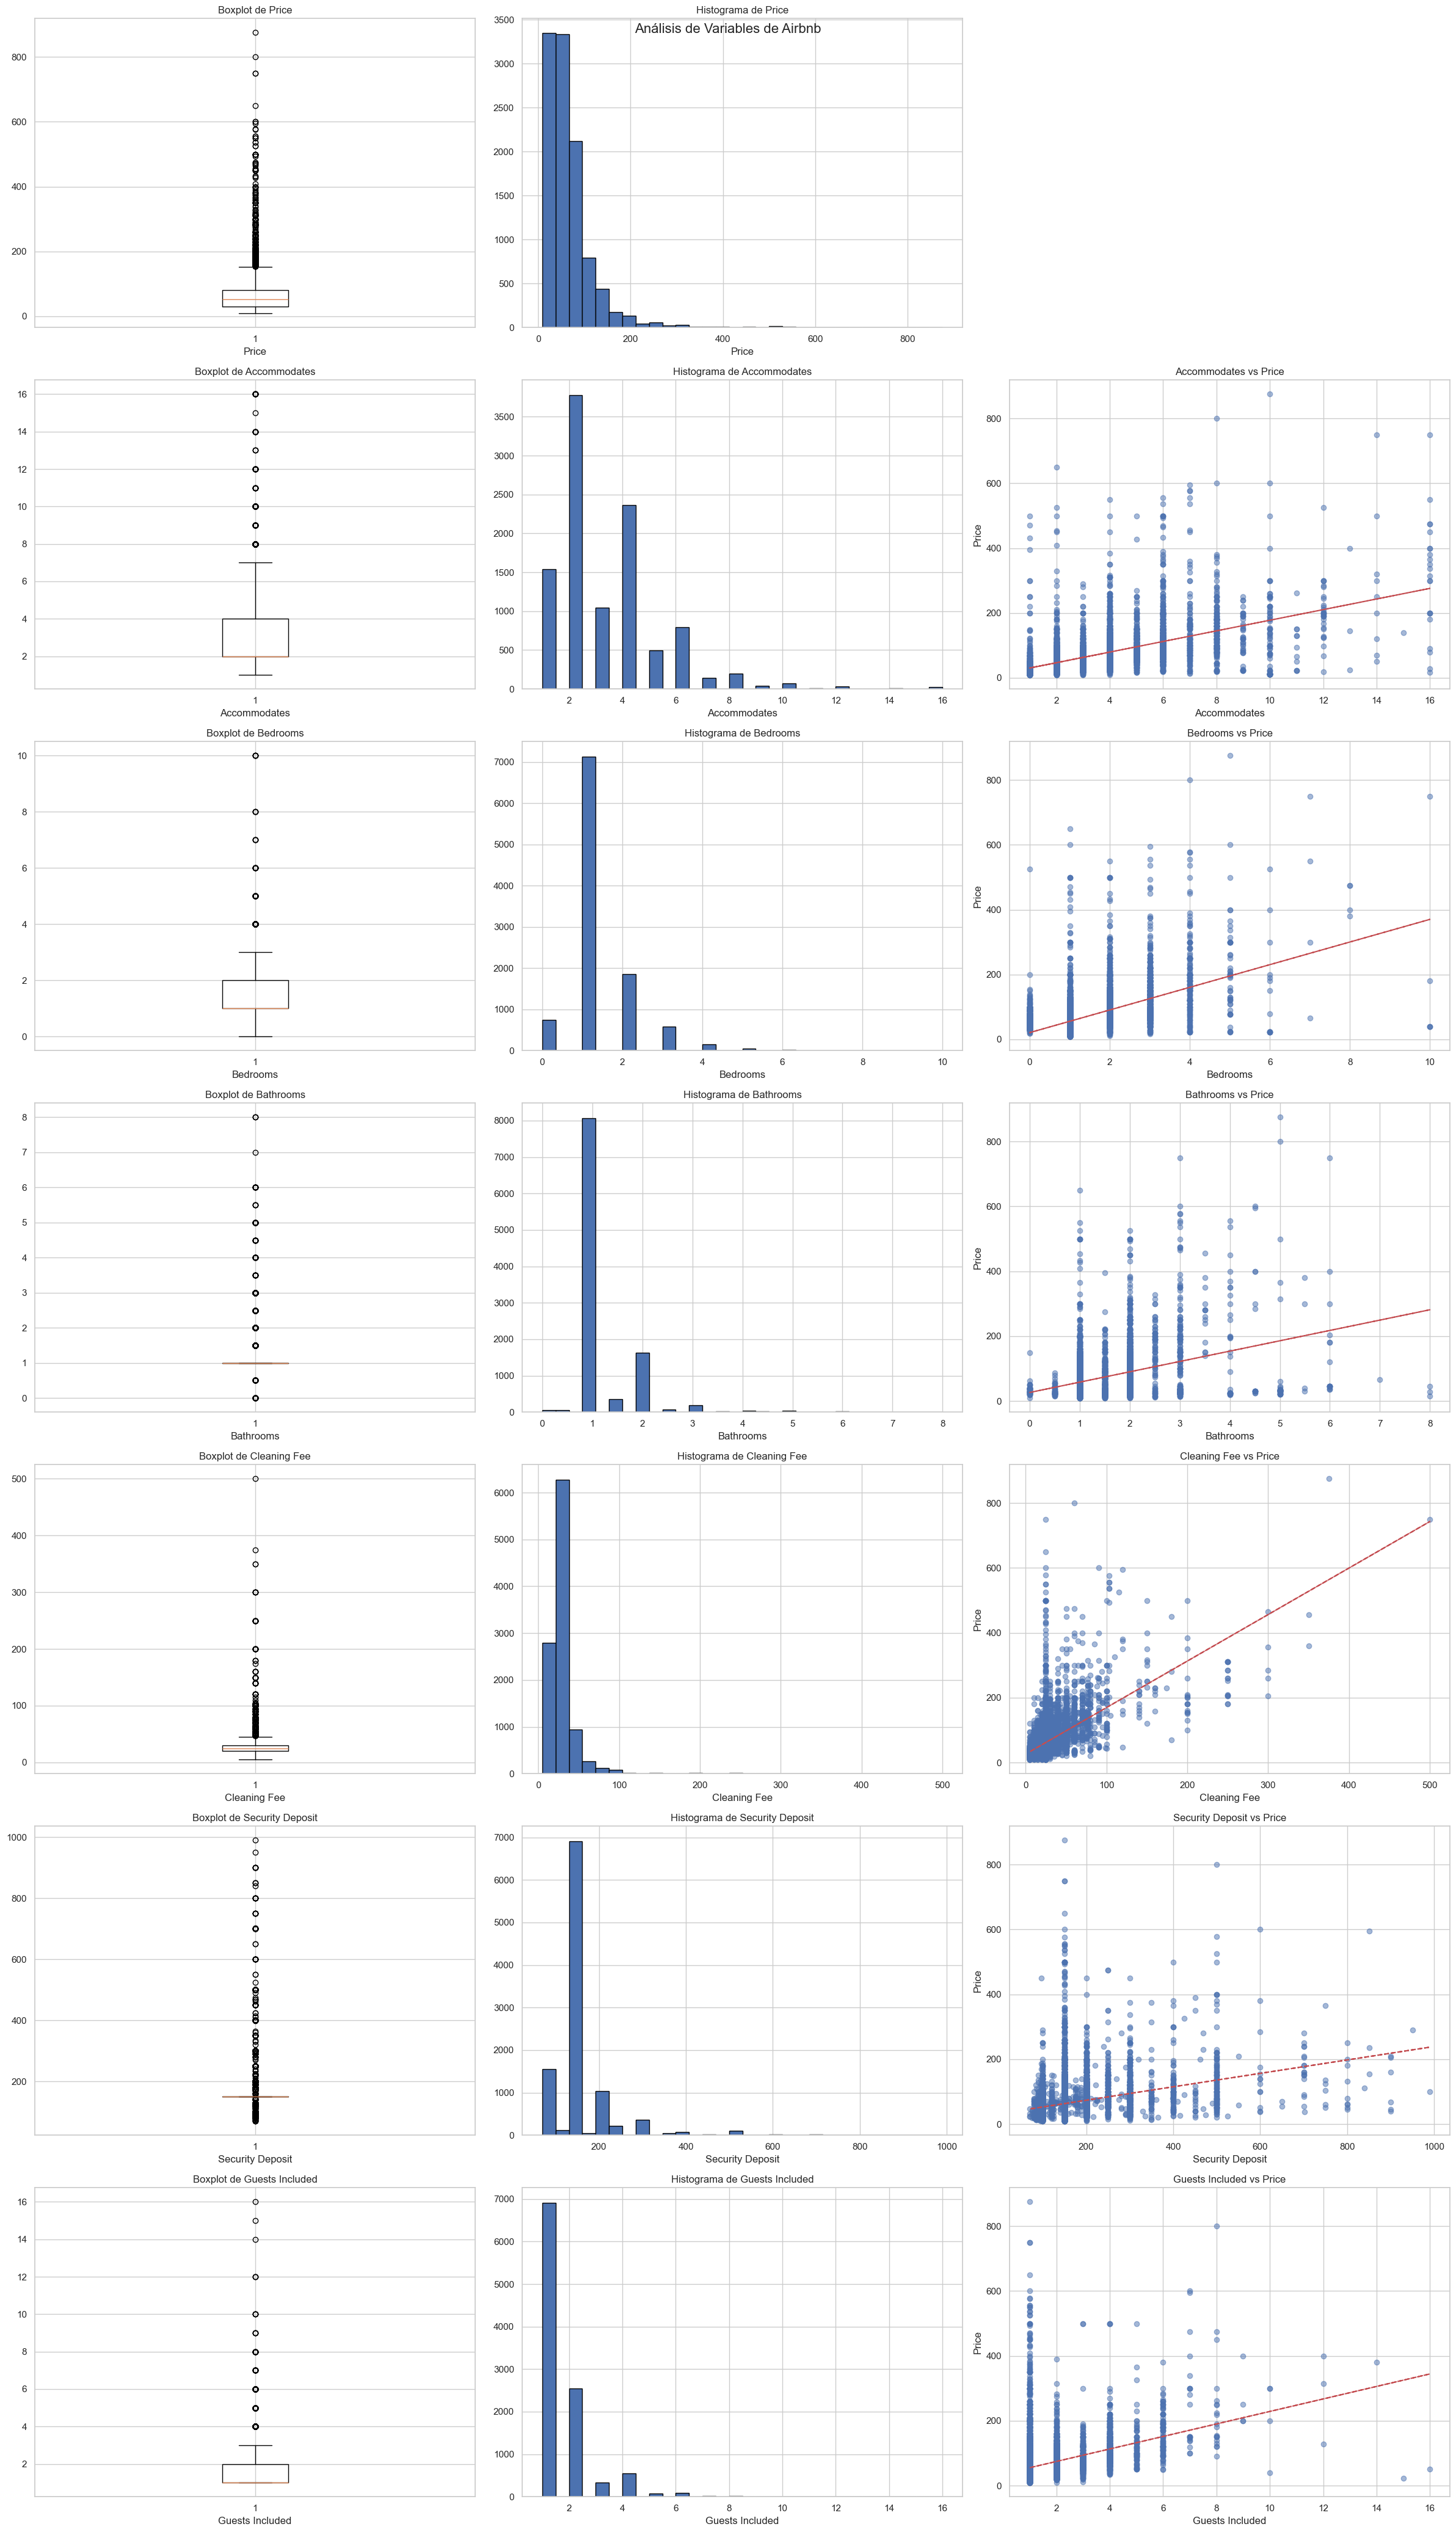

In [337]:
# Seleccionar las columnas más relevantes para visualizar
columns_to_plot = ['Price', 'Accommodates', 'Bedrooms', 'Bathrooms', 'Cleaning Fee', 'Security Deposit','Guests Included']

# Crear una figura con subplots
fig, axs = plt.subplots(len(columns_to_plot), 3, figsize=(24, 6*len(columns_to_plot)))
fig.suptitle('Análisis de Variables de Airbnb', fontsize=16)

for i, column in enumerate(columns_to_plot):
    # Boxplot
    axs[i, 0].boxplot(numeric_airbnb_madrid[column].dropna())
    axs[i, 0].set_title(f'Boxplot de {column}')
    axs[i, 0].set_xlabel(column)
    
    # Histograma
    axs[i, 1].hist(numeric_airbnb_madrid[column].dropna(), bins=30, edgecolor='black')
    axs[i, 1].set_title(f'Histograma de {column}')
    axs[i, 1].set_xlabel(column)
    
    # Gráfico de dispersión (solo para variables que no sean 'Price')
    if column != 'Price':
        axs[i, 2].scatter(numeric_airbnb_madrid[column], numeric_airbnb_madrid['Price'], alpha=0.5)
        axs[i, 2].set_title(f'{column} vs Price')
        axs[i, 2].set_xlabel(column)
        axs[i, 2].set_ylabel('Price')
        
        # Añadir una línea de tendencia al gráfico de dispersión
        z = np.polyfit(numeric_airbnb_madrid[column], numeric_airbnb_madrid['Price'], 1)
        p = np.poly1d(z)
        axs[i, 2].plot(numeric_airbnb_madrid[column], p(numeric_airbnb_madrid[column]), "r--")
    else:
        # Para 'Price', eliminamos el tercer gráfico
        fig.delaxes(axs[i, 2])

# Ajustar el layout
plt.tight_layout()
plt.show()

Análisis de Outliers
1. Precio (Price)
Media: $66.18
Mediana (50%): $53.
Percentil 75% : $80.
Máximo: $875.
Hay claros indicios de outliers en el precio:
- El máximo ($875) es significativamente más alto que el 75% percentil ($80).
La diferencia entre la media y la mediana sugiere una distribución sesgada con posibles outliers en el extremo superior.
2. Capacidad (Accommodates)
Media: 3.18.
Máximo: 16.
- El máximo de 16 personas podría considerarse un outlier, siendo casi 5 veces la media.
3. Baños (Bathrooms)
Media: 1.26.
Máximo: 8.
- Propiedades con 8 baños son atípicas y pueden considerarse outliers, siendo más de 6 veces la media.
4. Dormitorios (Bedrooms)
Media: 1.29.
Máximo: 10.
- Propiedades con 10 dormitorios son outliers potenciales, siendo más de 7 veces la media.
5. Número de Reseñas (Number of Reviews)
Media: 23.16.
Máximo: 356.
- Propiedades con 356 reseñas son outliers claros, siendo más de 15 veces la media.
6. Puntuaciones de Reseñas (Review Scores)
- La mayoría de las puntuaciones tienen un mínimo de 2, que podría considerarse un outlier en el extremo inferior, dado que la media está por encima de 9 para la mayoría de las categorías.

# Analizaremos la distribución de los precios

In [338]:
# Crear bins de 100 en 100
max_price = numeric_airbnb_madrid['Price'].max()
bins = range(0, int(max_price) + 101, 100)

# Crear una serie con la distribución de precios
price_distribution = pd.cut(numeric_airbnb_madrid['Price'], bins=bins).value_counts().sort_index()

# Renombrar los índices para mayor claridad
price_distribution.index = [f'{i}-{i+99}' for i in range(0, int(max_price) + 1, 100)]

# Mostrar la distribución
print("Distribución de alojamientos por rango de precios:")
print(price_distribution)

# Calcular y mostrar el total
total = price_distribution.sum()
print(f"\nTotal de alojamientos: {total}")

Distribución de alojamientos por rango de precios:
0-99       9144
100-199    1166
200-299     164
300-399      41
400-499      26
500-599      13
600-699       1
700-799       3
800-899       1
Name: count, dtype: int64

Total de alojamientos: 10559


Después de realizar validaciones determinamos quedarnos con los valores menores de 300 

In [339]:
airbnb_madrid_no_outliers = numeric_airbnb_madrid[numeric_airbnb_madrid['Price'] <= 300]

# Imprimir el número de registros eliminados

print(
    f'Original: {numeric_airbnb_madrid.shape[0]} // '
    f'Modificado: {airbnb_madrid_no_outliers.shape[0]}\nDiferencia: {numeric_airbnb_madrid.shape[0] - airbnb_madrid_no_outliers.shape[0]}'
)
print(f'Variación: {((numeric_airbnb_madrid.shape[0] - airbnb_madrid_no_outliers.shape[0])/numeric_airbnb_madrid.shape[0])*100:2f}%')


Original: 10559 // Modificado: 10474
Diferencia: 85
Variación: 0.805000%


Revisemos las variables categóricas

In [340]:
categorical_airbnb_madrid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10567 entries, 0 to 11823
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Neighbourhood                 7040 non-null   object
 1   Neighbourhood Cleansed        10567 non-null  object
 2   Neighbourhood Group Cleansed  10567 non-null  object
 3   City                          10567 non-null  object
 4   State                         10530 non-null  object
 5   Zipcode                       10220 non-null  object
 6   Market                        10528 non-null  object
 7   Country Code                  10567 non-null  object
 8   Country                       10567 non-null  object
 9   Property Type                 10567 non-null  object
 10  Room Type                     10567 non-null  object
 11  Bed Type                      10567 non-null  object
 12  Amenities                     10477 non-null  object
 13  Cancellation Policy  

In [341]:
categorical_airbnb_madrid.describe()

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Country Code,Country,Property Type,Room Type,Bed Type,Amenities,Cancellation Policy
count,7040,10567,10567,10567,10530,10220,10528,10567,10567,10567,10567,10567,10477,10567
unique,65,125,21,1,13,68,4,1,1,20,3,5,9030,5
top,Malasaña,Embajadores,Centro,Madrid,Comunidad de Madrid,28012,Madrid,ES,Spain,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",strict
freq,693,1479,5419,10567,8495,1660,10520,10567,10567,8741,6333,10335,38,3984


# Análisis.
1. Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed:
Para el análisis de precios utilizaremos Neighbourhood Group Cleansed por las siguientes razones:
- Cobertura completa: Tiene datos para todos los registros, lo que evita la pérdida de información.
- Nivel de granularidad adecuado: Con 21 categorías, ofrece un buen balance entre detalle y generalización. Esto facilitará el análisis sin ser demasiado específico ni demasiado amplio.
- Datos limpios: Al ser una versión "limpia", es probable que haya pasado por un proceso de estandarización, reduciendo errores o inconsistencias.
- Facilidad de interpretación: Un número manejable de categorías permitirá una interpretación más clara de los resultados y la creación de visualizaciones más comprensibles.
2. City	State,	Zipcode, Market, Country Code, Country, Bed Type: Estas variables no son útiles para el análisis de precios por las siguientes razones:
- Falta de variabilidad: La mayoría de estas variables tienen un único valor o muy poca variación, lo que no permite diferenciar entre los alojamientos.
- Irrelevancia geográfica: Para un análisis centrado en Madrid, variables como país o comunidad autónoma no aportan información significativa.
- Redundancia: La información geográfica relevante ya está mejor capturada en la variable Neighbourhood Group Cleansed que hemos seleccionado anteriormente.
3. Property Type, Room Type, Cancellation Policy:Utilizaremos estas variables ya que ofrecen una variedad significativa de tipos de propiedades que pueden influir en el precio o son un factor crucial en la determinación del precio.
4. Amenities: La alta variabilidad hace que sea extremadamente difícil categorizar o analizar de manera efectiva sin un procesamiento extenso y  el formato de texto libre hace que sea complicado cuantificar o comparar amenidades entre propiedades de manera sistemática.

In [342]:
def plot_categorical_variables(dataframe, list_categorical_columns):
    for variable in list_categorical_columns: # recorremos las variable categóricas
        plt.figure() # creamos la figura
        dataframe[variable].value_counts().sort_index().plot(kind='bar', title=variable) # rellenamos la figura con un gráfico de barras

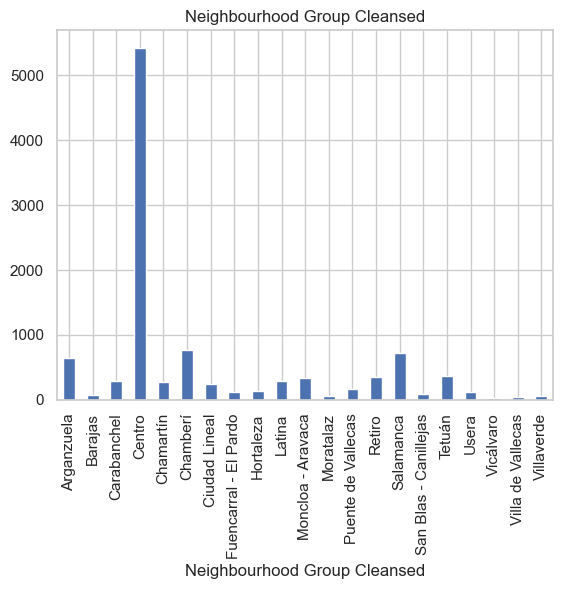

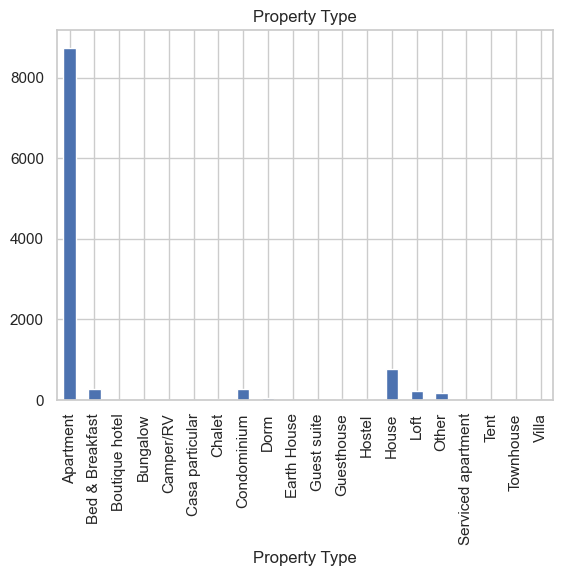

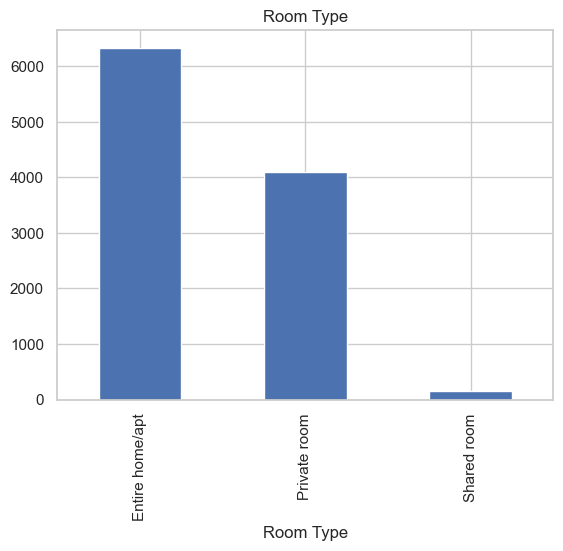

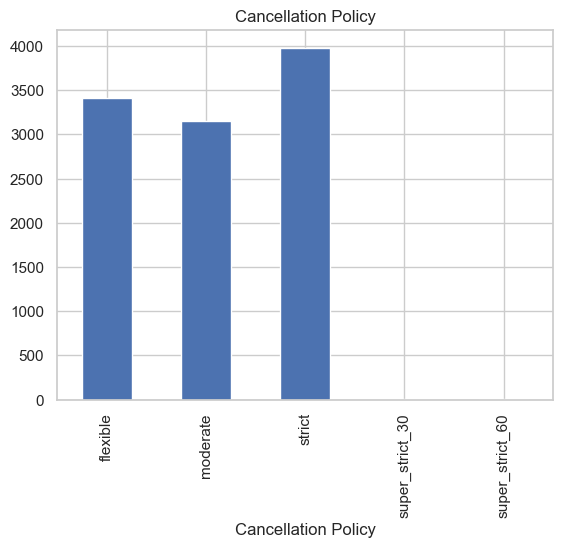

In [343]:
columns_categorical=['Neighbourhood Group Cleansed','Property Type','Room Type','Cancellation Policy']
plot_categorical_variables(categorical_airbnb_madrid,columns_categorical)

## 4. Generación de nuevas características


In [344]:
airbnb_data['Bathrooms_per_person'] = airbnb_data['Bathrooms'] / airbnb_data['Accommodates']
airbnb_data['Beds_per_person'] = airbnb_data['Beds'] / airbnb_data['Accommodates']
airbnb_data['Bedrooms_squared'] = airbnb_data['Bedrooms'].apply(lambda x: x**2)
airbnb_data['Bed_bath_rooms']   = airbnb_data['Bedrooms']*airbnb_data['Bathrooms']

## 5. Modelado, cross-validation y estudio de resultados en train y test

Antes de modelar, tenemos que cargar los datos de test y aplicar exactamente las mismas transformaciones. Es buena práctica, llegado este momento, combinar todo nuestro preprocesamiento en una única celda:

In [345]:
# Cargar los datos de train
airbnb_data = pd.read_csv('airbnb_data_cleaned_train.csv', sep=';', decimal='.')

# 1. Filtrar los datos para mantener solo las entradas de Madrid y los precios
airbnb_data = airbnb_data[airbnb_data['City'] == 'Madrid']
airbnb_data = airbnb_data[airbnb_data['Price'] < 300]

# 2. Manejo de valores nulos
airbnb_data = airbnb_data.dropna(subset=['Price'])  # Eliminar filas donde Price es NaN

#  Aplicar el logaritmo al precio
airbnb_data = airbnb_data[airbnb_data['Price'] > 0]  # Filtrar precios no válidos
airbnb_data['log_price'] = np.log(airbnb_data['Price'])  # Crear columna logarítmica

# Imputar valores faltantes en Review Scores
review_score_columns = [col for col in airbnb_data.columns if col.startswith('Review Scores')]
airbnb_data[review_score_columns] = airbnb_data[review_score_columns].fillna(airbnb_data[review_score_columns].mean())

# Imputar valores nulos en columnas importantes
columns_to_impute = ['Bathrooms', 'Bedrooms', 'Beds']
for col in columns_to_impute:
    airbnb_data[col] = airbnb_data[col].fillna(airbnb_data[col].median())

# 3. Crear características derivadas
airbnb_data['Bathrooms_per_person'] = airbnb_data['Bathrooms'] / airbnb_data['Accommodates']
airbnb_data['Beds_per_person'] = airbnb_data['Beds'] / airbnb_data['Accommodates']
airbnb_data['Bedrooms_squared'] = airbnb_data['Bedrooms'].apply(lambda x: x**2)
airbnb_data['Bed_bath_rooms']   = airbnb_data['Bedrooms']*airbnb_data['Bathrooms']

# Manejar Security Deposit y Cleaning Fee
airbnb_data['Security Deposit'] = airbnb_data['Security Deposit'].fillna(0)
airbnb_data['Cleaning Fee'] = airbnb_data['Cleaning Fee'].fillna(0)
airbnb_data['Total Additional Cost'] = airbnb_data['Security Deposit'] + airbnb_data['Cleaning Fee']

# 4. Eliminar características con muchos valores nulos
airbnb_data = airbnb_data.drop(['Square Feet', 'Weekly Price', 'Monthly Price'], axis=1)

# 5. Codificar variables categóricas
# Crear variables dummy para Room Type, Property Type y Cancellation Policy
columns_to_dummify = ['Room Type', 'Property Type', 'Cancellation Policy']
airbnb_data = pd.get_dummies(airbnb_data, columns=columns_to_dummify, drop_first=True)

# Manejar Neighbourhood Group Cleansed por separado
airbnb_data = pd.get_dummies(airbnb_data, columns=['Neighbourhood Group Cleansed'], prefix='NGC')

# Identificar las columnas dummy creadas
dummy_columns = [col for col in airbnb_data.columns if col.startswith(('Room Type_', 'Property Type_', 'Cancellation Policy_', 'NGC_'))]

# Convertir solo las columnas dummy a int8
airbnb_data[dummy_columns] = airbnb_data[dummy_columns].astype('int8')


In [346]:
# Cargar los datos de test
airbnb_data_test = pd.read_csv('airbnb_data_cleaned_test.csv', sep=';', decimal='.')

# 1. Filtrar los datos para mantener solo las entradas de Madrid y los precios
airbnb_data_test = airbnb_data_test[airbnb_data_test['City'] == 'Madrid']
airbnb_data_test = airbnb_data_test[airbnb_data_test['Price'] < 300]

# 2. Manejo de valores nulos
airbnb_data_test = airbnb_data_test.dropna(subset=['Price'])  # Eliminar filas donde Price es NaN

# Aplicar el logaritmo al precio
airbnb_data_test = airbnb_data_test[airbnb_data_test['Price'] > 0]  # Filtrar precios no válidos
airbnb_data_test['log_price'] = np.log(airbnb_data_test['Price'])  # Crear columna logarítmica

# Imputar valores faltantes en Review Scores usando la media del conjunto de entrenamiento
review_score_columns = [col for col in airbnb_data_test.columns if col.startswith('Review Scores')]
# Calcular medias del conjunto de entrenamiento
review_score_means = airbnb_data[review_score_columns].mean()  
airbnb_data_test[review_score_columns] = airbnb_data_test[review_score_columns].fillna(review_score_means)

# Imputar valores nulos en columnas importantes usando la mediana del conjunto de entrenamiento
columns_to_impute = ['Bathrooms', 'Bedrooms', 'Beds']
for col in columns_to_impute:
    # Usar la mediana del conjunto de entrenamiento para imputar
    airbnb_data_test[col] = airbnb_data_test[col].fillna(airbnb_data[col].median())

# 3. Crear características derivadas
airbnb_data_test['Bathrooms_per_person'] = airbnb_data_test['Bathrooms'] / airbnb_data_test['Accommodates']
airbnb_data_test['Beds_per_person'] = airbnb_data_test['Beds'] / airbnb_data_test['Accommodates']
airbnb_data_test['Bedrooms_squared'] = airbnb_data_test['Bedrooms'].apply(lambda x: x**2)
airbnb_data_test['Bed_bath_rooms']   = airbnb_data_test['Bedrooms']*airbnb_data_test['Bathrooms']

# Manejar Security Deposit y Cleaning Fee
airbnb_data_test['Security Deposit'] = airbnb_data_test['Security Deposit'].fillna(0)
airbnb_data_test['Cleaning Fee'] = airbnb_data_test['Cleaning Fee'].fillna(0)
airbnb_data_test['Total Additional Cost'] = airbnb_data_test['Security Deposit'] + airbnb_data_test['Cleaning Fee']

# 4. Eliminar características con muchos valores nulos
airbnb_data_test = airbnb_data_test.drop(['Square Feet', 'Weekly Price', 'Monthly Price'], axis=1)

# 5. Codificar variables categóricas
# Crear variables dummy para Room Type, Property Type y Cancellation Policy
columns_to_dummify = ['Room Type', 'Property Type', 'Cancellation Policy']
airbnb_data_test = pd.get_dummies(airbnb_data_test, columns=columns_to_dummify, drop_first=True)

# Manejar Neighbourhood Group Cleansed por separado
airbnb_data_test = pd.get_dummies(airbnb_data_test, columns=['Neighbourhood Group Cleansed'], prefix='NGC')

# Identificar las columnas dummy creadas
dummy_columns = [col for col in airbnb_data_test.columns if col.startswith(('Room Type_', 'Property Type_', 'Cancellation Policy_', 'NGC_'))]

# Convertir solo las columnas dummy a int8
airbnb_data_test[dummy_columns] = airbnb_data_test[dummy_columns].astype('int8')

# Añadir columnas faltantes y eliminar columnas extra
train_columns = set(airbnb_data.columns)
test_columns = set(airbnb_data_test.columns)
for col in train_columns - test_columns:
    airbnb_data_test[col] = 0
airbnb_data_test = airbnb_data_test[airbnb_data.columns]


Ahora podemos preparar los datos para sklearn:

In [349]:
# Dataset de train
# Preparar los datos para el modelado
features = airbnb_data.drop(['Price','log_price'],axis=1).select_dtypes(include=[np.number]).columns

y_train = airbnb_data['log_price']  # nos quedamos con la columna, Price o log_price
X_train = airbnb_data[features]  # nos quedamos con el resto


# Dataset de test

y_test = airbnb_data_test['log_price']  # nos quedamos con la columna, Price o log_price
X_test = airbnb_data_test[features]  # nos quedamos con el resto


# Verificar las formas de los conjuntos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

# Verificar las columnas en X_train y X_test
print("\nColumnas en X_train:")
print(X_train.columns.tolist())

print("\nColumnas en X_test:")
print(X_test.columns.tolist())

# Verificar los primeros registros de X_train y y_train
print("\nPrimeros registros de X_train:")
print(X_train.head())

print("\nPrimeros registros de y_train:")
print(y_train.head())

Forma de X_train: (10456, 75)
Forma de y_train: (10456,)
Forma de X_test: (2617, 75)
Forma de y_test: (2617,)

Columnas en X_train:
['Latitude', 'Longitude', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Security Deposit', 'Cleaning Fee', 'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Bathrooms_per_person', 'Beds_per_person', 'Bedrooms_squared', 'Bed_bath_rooms', 'Total Additional Cost', 'Room Type_Private room', 'Room Type_Shared room', 'Property Type_Bed & Breakfast', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Camper/RV', 'Property Type_Casa particular', 'Property Type_Chalet', 'Property Type_Condominium', 'Property Type_Dorm', 'Property Type_Earth 

Y si queremos, podemos normalizar, pero con los datos de train!

In [350]:
# Escalamos (con los datos de train)
scaler = StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# Esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

Ahora vendría lo-de-siempre: cross validation, búsqueda de los parámetros óptimos, visualización de performance vs complejidad...

#  Entrenamos un Lasso usando Grid Search.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best mean cross-validation score: -0.116
best parameters: {'alpha': 0.0006158482110660267}


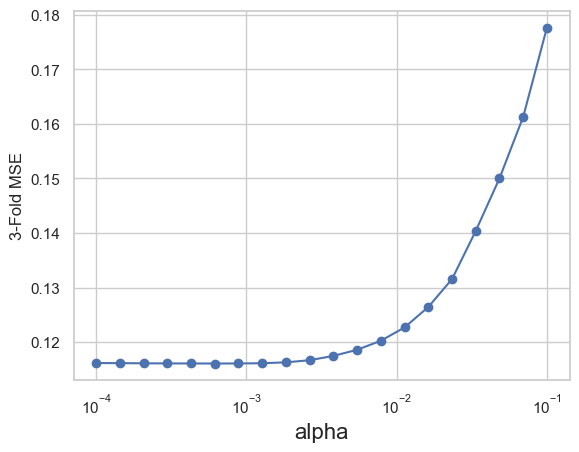

In [351]:
alpha_vector =  np.logspace(-4,-1,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('3-Fold MSE')
plt.show()



Métricas de rendimiento del modelo Lasso:
MSE (train): 0.11
MSE (test): 0.12
RMSE (train): 0.34
RMSE (test): 0.35
R2 (train): 0.7208
R2 (test): 0.7143


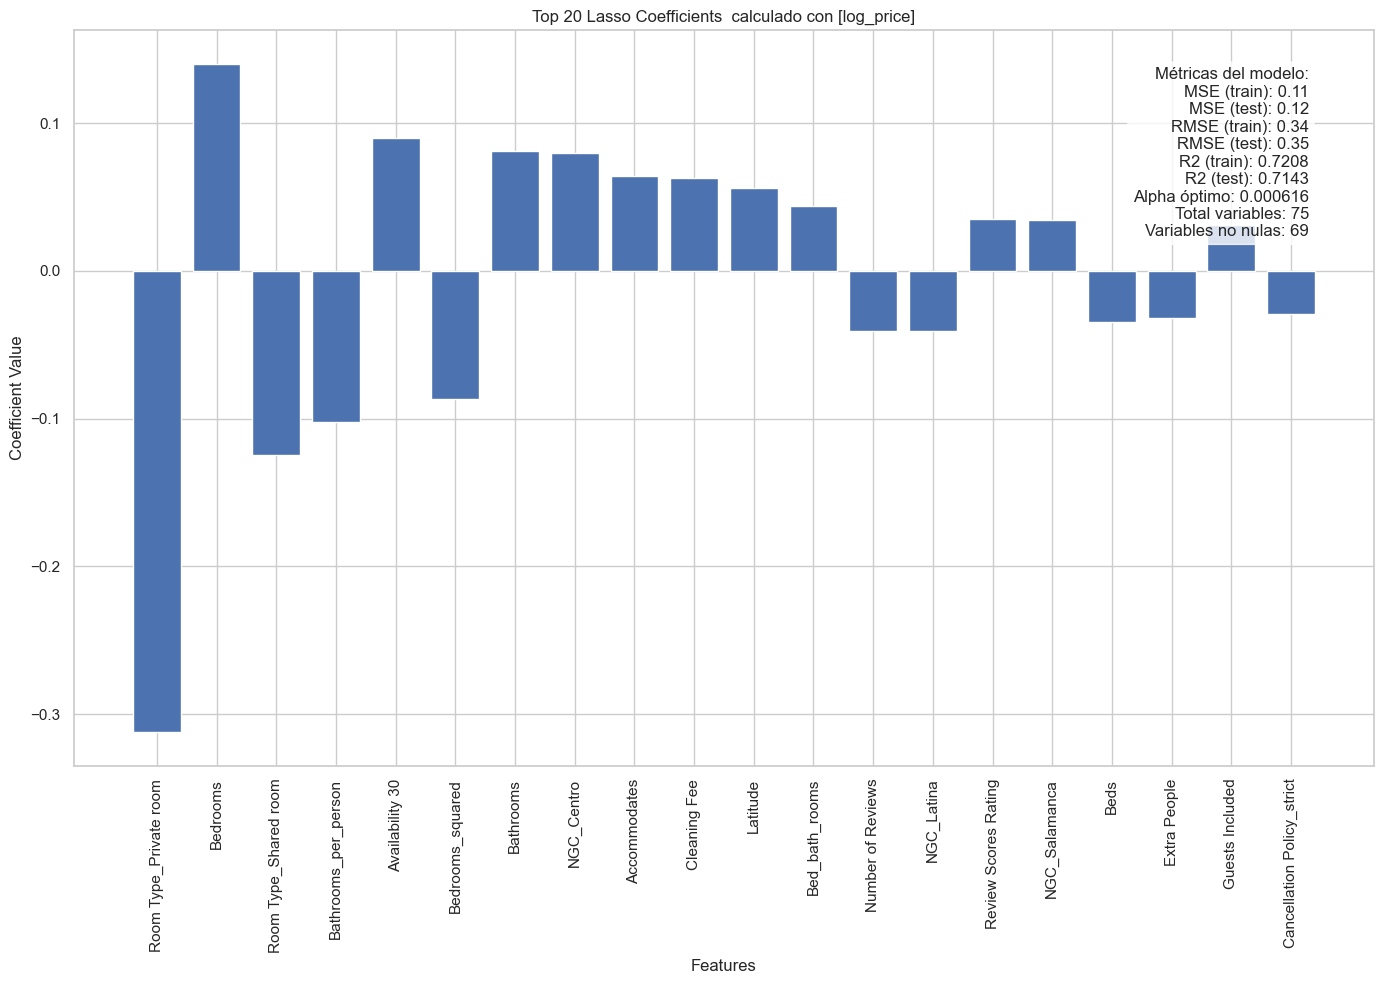

In [352]:
# Obtener el mejor alpha del GridSearchCV
alpha_optimo = grid.best_params_['alpha']

# Entrenar el modelo Lasso con el alpha óptimo
lasso = Lasso(alpha=alpha_optimo)
lasso.fit(XtrainScaled, y_train)

# Hacer predicciones
y_train_pred = lasso.predict(XtrainScaled)
y_test_pred = lasso.predict(XtestScaled)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir métricas
print("\nMétricas de rendimiento del modelo Lasso:")
print(f"MSE (train): {mse_train:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (train): {rmse_train:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R2 (train): {r2_train:.4f}")
print(f"R2 (test): {r2_test:.4f}")

# Análisis de coeficientes
feature_names = X_train.columns
coefficients = lasso.coef_

# Crear un DataFrame con las características y sus coeficientes
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

top = coef_df_sorted.head(20)
# Visualizar los coeficientes

plt.figure(figsize=(14, 10))
plt.bar(top['Feature'], top['Coefficient'])
plt.xticks(rotation=90)
plt.title(f'Top {len(top)} Lasso Coefficients  calculado con [log_price]')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

# Crear el cuadro de texto con las métricas
metrics_text = f"""Métricas del modelo:
MSE (train): {mse_train:.2f}
MSE (test): {mse_test:.2f}
RMSE (train): {rmse_train:.2f}
RMSE (test): {rmse_test:.2f}
R2 (train): {r2_train:.4f}
R2 (test): {r2_test:.4f}
Alpha óptimo: {alpha_optimo:.6f}
Total variables: {len(feature_names)}
Variables no nulas: {np.sum(coefficients != 0)}"""

# Añadir el cuadro de texto al gráfico 
plt.text(0.95, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#  Entrenamos un BaggingRegressor usando Grid Search.

Fitting 5 folds for each of 14 candidates, totalling 70 fits
best mean cross-validation score: -0.099
best parameters: {'estimator__max_depth': 12}


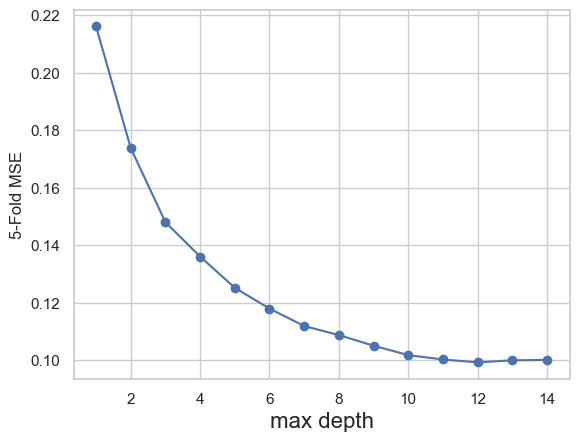

In [353]:
max_depth_vector = range(1,15)
param_grid = {'estimator__max_depth': max_depth_vector}
grid = GridSearchCV(
    BaggingRegressor(estimator=DecisionTreeRegressor(random_state=0)),
    scoring= 'neg_mean_squared_error',
    param_grid=param_grid,
    cv = 5,
    verbose=1
).fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.plot(max_depth_vector,scores,'-o')
plt.xlabel('max depth',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [354]:
maxDepthOptimo = 10  #grid.best_params_['estimator__max_depth']
baggingModel = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=maxDepthOptimo),
    n_estimators=200
).fit(X_train,y_train)

print("Train: ", baggingModel.score(X_train,y_train))
print("Test: ", baggingModel.score(X_test,y_test))

Train:  0.8427819873019664
Test:  0.7624608940350779


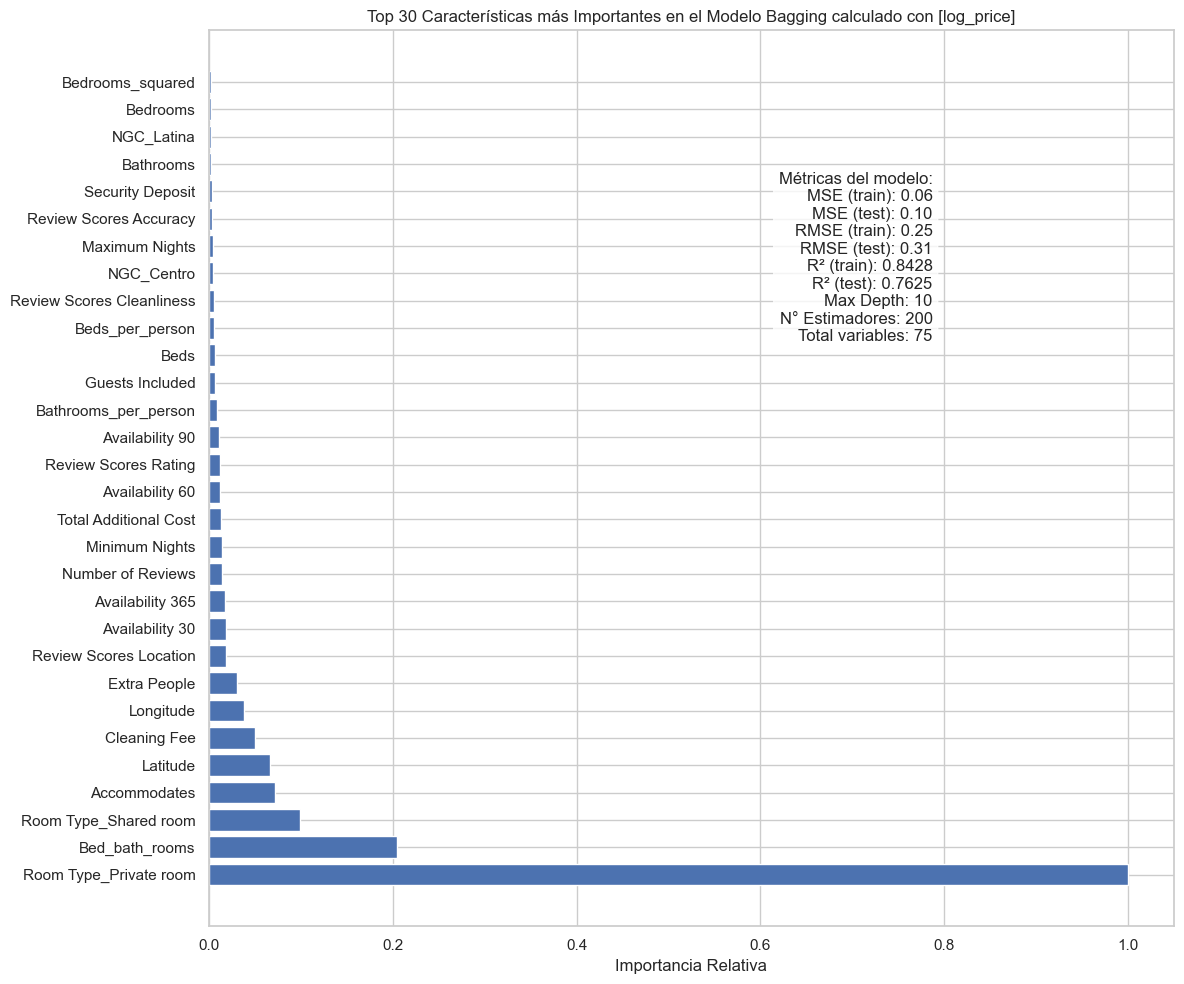

In [355]:
# Número de características a mostrar
num_features_to_show = 30

# Calcular las importancias de las características
importances = np.mean([tree.feature_importances_ for tree in baggingModel.estimators_], axis=0)
importances = importances / np.max(importances)
feature_names = features
indices = np.argsort(importances)[::-1]

# Calcular métricas adicionales
train_score = baggingModel.score(X_train, y_train)
test_score = baggingModel.score(X_test, y_test)
y_train_pred = baggingModel.predict(X_train)
y_test_pred = baggingModel.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Crear el gráfico
plt.figure(figsize=(12, 10))
plt.barh(range(num_features_to_show), importances[indices][:num_features_to_show])
plt.yticks(range(num_features_to_show), [features[i] for i in indices[:num_features_to_show]])
plt.xlabel('Importancia Relativa')
plt.title(f'Top {num_features_to_show} Características más Importantes en el Modelo Bagging calculado con [log_price]')

# Crear el cuadro de texto con las métricas
metrics_text = f"""Métricas del modelo:
MSE (train): {mse_train:.2f}
MSE (test): {mse_test:.2f}
RMSE (train): {rmse_train:.2f}
RMSE (test): {rmse_test:.2f}
R² (train): {train_score:.4f}
R² (test): {test_score:.4f}
Max Depth: {maxDepthOptimo}
N° Estimadores: 200
Total variables: {len(feature_names)}"""

# Añadir el cuadro de texto al gráfico (en la esquina superior derecha)
plt.text(0.75, 0.65, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=12)

plt.tight_layout()
plt.show()


## Entrenamos un RandomForestRegressor usando Grid Search.

Fitting 5 folds for each of 14 candidates, totalling 70 fits
best mean cross-validation score: -0.097
best parameters: {'max_depth': 14}


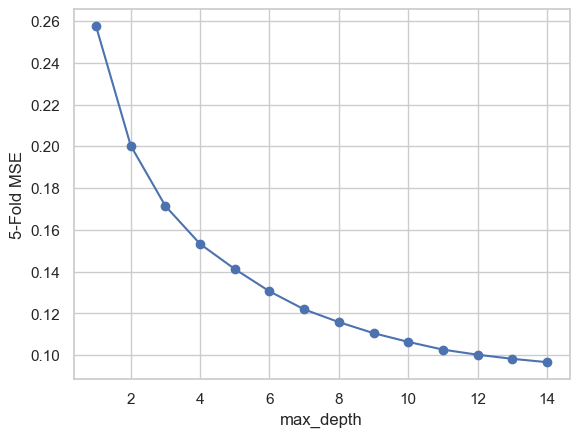

In [356]:
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'),
       param_grid=tuned_parameters,cv=5, verbose=1,scoring='neg_mean_squared_error')  
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -np.array(grid.cv_results_['mean_test_score']) # Negamos para convertir a MSE
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('5-Fold MSE')

plt.show()

In [357]:
maxDepthOptimo = 12  #grid.best_params_['max_depth']
randomForest = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",randomForest.score(X_train,y_train))
print("Test: ",randomForest.score(X_test,y_test))

Train:  0.8485070186344739
Test:  0.7555940830329462


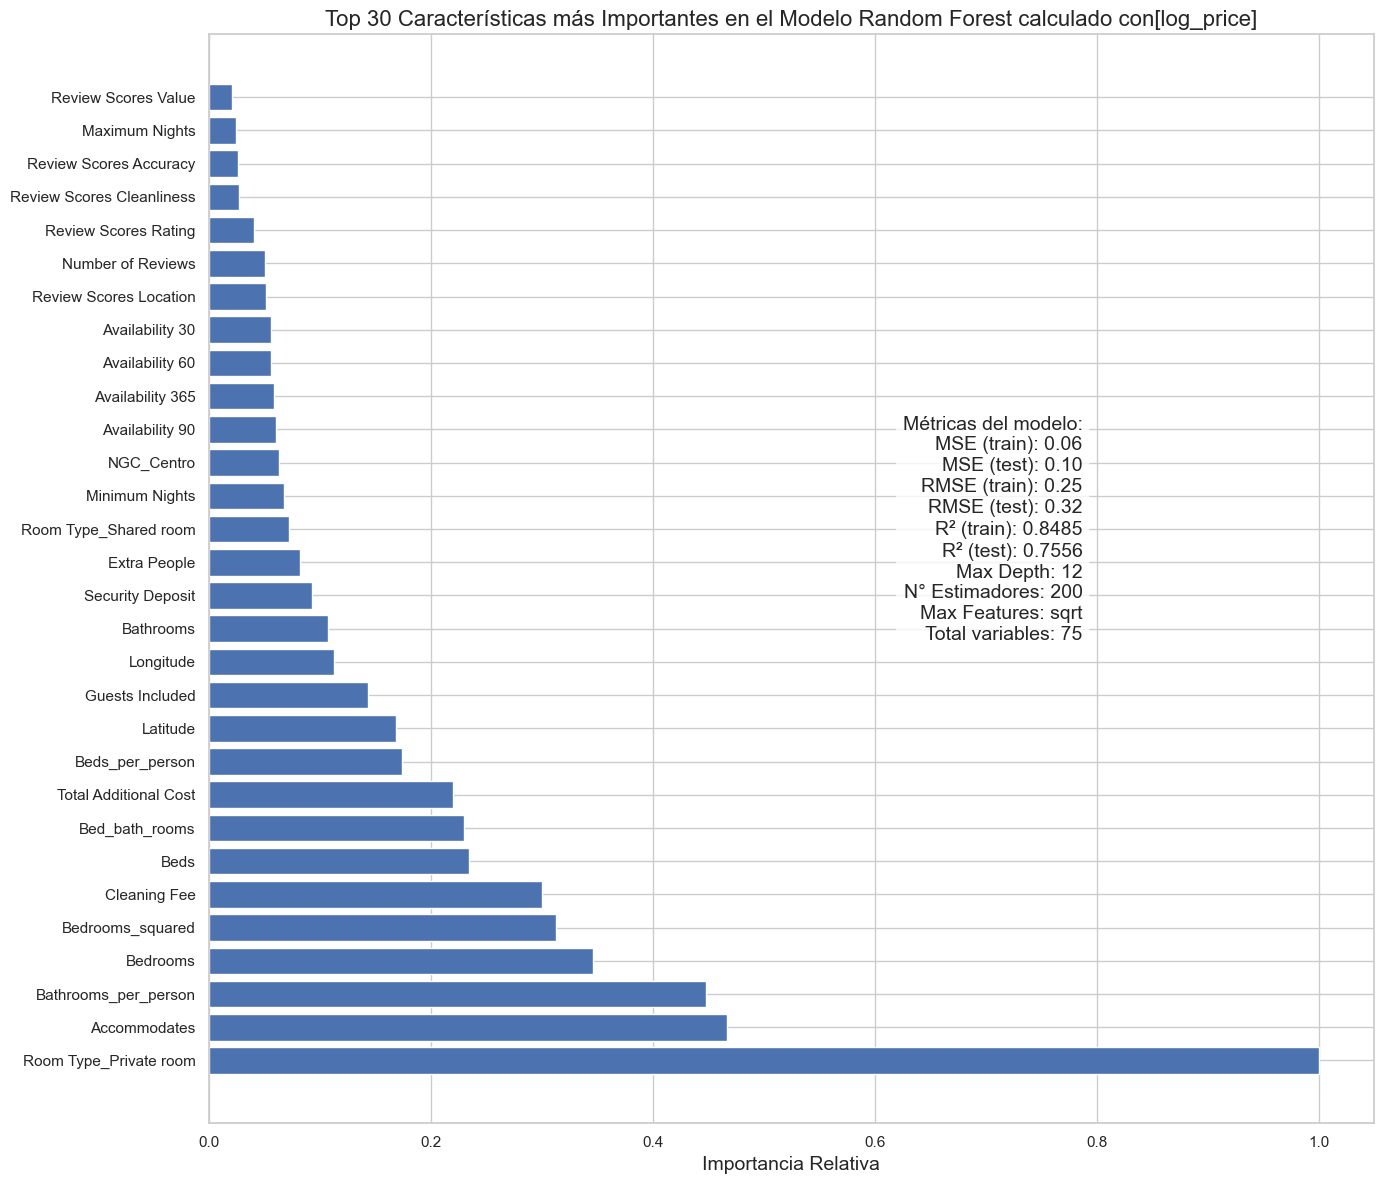

In [358]:
# Número de características a mostrar
num_features_to_show = 30

# Calcular métricas (si no están ya calculadas)
train_score = randomForest.score(X_train, y_train)
test_score = randomForest.score(X_test, y_test)
y_train_pred = randomForest.predict(X_train)
y_test_pred = randomForest.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calcular importancias de características
importances = randomForest.feature_importances_
importances = importances / np.max(importances)
indices = np.argsort(importances)[::-1]

# Crear el gráfico para las primeras num_features_to_show características
plt.figure(figsize=(14, 12))
plt.barh(range(num_features_to_show), importances[indices][:num_features_to_show])
plt.yticks(range(num_features_to_show), [features[i] for i in indices[:num_features_to_show]])
plt.xlabel('Importancia Relativa', fontsize=14)
plt.title(f'Top {num_features_to_show} Características más Importantes en el Modelo Random Forest calculado con[log_price]', fontsize=16)

# Crear el cuadro de texto con las métricas
metrics_text = f"""Métricas del modelo:
MSE (train): {mse_train:.2f}
MSE (test): {mse_test:.2f}
RMSE (train): {rmse_train:.2f}
RMSE (test): {rmse_test:.2f}
R² (train): {train_score:.4f}
R² (test): {test_score:.4f}
Max Depth: {randomForest.max_depth}
N° Estimadores: {randomForest.n_estimators}
Max Features: {randomForest.max_features}
Total variables: {len(feature_names)}"""

# Añadir el cuadro de texto al gráfico (en la esquina superior derecha)
plt.text(0.75, 0.65, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         fontsize=14)

plt.tight_layout()
plt.show()


# Seleccion de características usando RandomForestRegressor y Validación cruzada

In [359]:
N, Nfeatures = X_train.shape
maxDepthOptimo = 10
rf = RandomForestRegressor(max_depth=maxDepthOptimo, n_estimators=20, max_features='sqrt')
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_error = []
cv_std = []

all_importances = []  # Para almacenar las importancias de cada iteración

for nfeatures in range(Nfeatures, 0, -1):
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        Xt = X_train.iloc[idxTrain, :]
        yt = y_train.iloc[idxTrain]
        Xv = X_train.iloc[idxVal, :]
        yv = y_train.iloc[idxVal]
        
        rf.fit(Xt, yt)
        
        ranking = rf.feature_importances_
        all_importances.append(ranking)  # Agregamos las importancias de esta iteración
        
        # Usamos el promedio de importancias acumuladas hasta ahora
        average_importances = np.mean(all_importances, axis=0)
        indices = np.argsort(average_importances)[::-1]
        
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt.iloc[:, selected]
        
        rf.fit(Xs, yt)
        error = (1.0 - rf.score(Xv.iloc[:, selected], yv))
        error_i.append(error)
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    #print(f'# features {len(selected)} error {np.mean(error_i):.4f} +/- {np.std(error_i):.4f}')

# Calculamos el ranking final de importancias
final_importances = np.mean(all_importances, axis=0)
final_indices = np.argsort(final_importances)[::-1]

# Seleccionamos las 30 características más importantes
selected_features = final_indices[:30]

# Entrenamos un modelo final con las 30 características más importantes
final_rf = RandomForestRegressor(max_depth=12, n_estimators=200)
final_rf.fit(X_train.iloc[:, selected_features], y_train)

# Evaluamos el modelo final
print("Train score:", final_rf.score(X_train.iloc[:, selected_features], y_train))
print("Test score:", final_rf.score(X_test.iloc[:, selected_features], y_test))

# 30 características más importantes:
top_30_features = X_train.columns[selected_features]
print("Top 30 features:", top_30_features.tolist())

Train score: 0.883688545712618
Test score: 0.7730679624422128
Top 30 features: ['Room Type_Private room', 'Accommodates', 'Bathrooms_per_person', 'Bedrooms', 'Bedrooms_squared', 'Cleaning Fee', 'Bed_bath_rooms', 'Beds', 'Total Additional Cost', 'Beds_per_person', 'Latitude', 'Guests Included', 'Bathrooms', 'Security Deposit', 'Longitude', 'Extra People', 'Room Type_Shared room', 'Minimum Nights', 'NGC_Centro', 'Review Scores Location', 'Availability 365', 'Availability 90', 'Availability 30', 'Availability 60', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Maximum Nights', 'NGC_Latina']


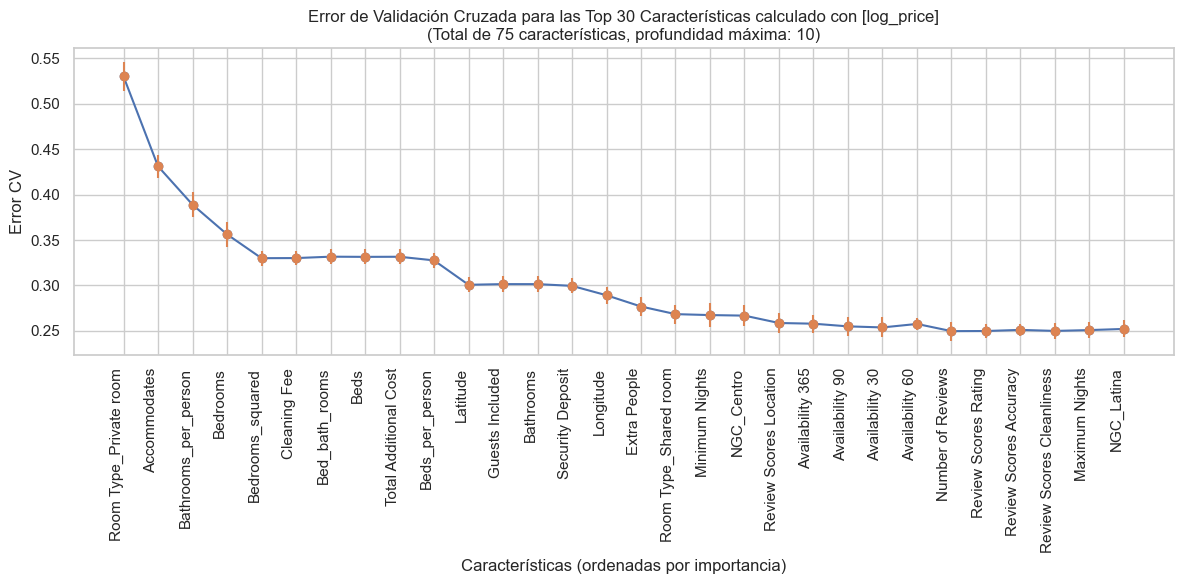

In [360]:
feature_names = features

# Número de características a mostrar
num_features_to_show = 30

# Crear el gráfico
plt.figure(figsize=(12, 6))  # Aumentado el tamaño para mejor visibilidad

# Plotear el error CV solo para las primeras 30 características
plt.plot(range(1, num_features_to_show + 1), cv_error[:num_features_to_show], '-o')
plt.errorbar(range(1, num_features_to_show + 1), cv_error[:num_features_to_show], 
             yerr=cv_std[:num_features_to_show], fmt='o')

# Preparar las etiquetas del eje X para las primeras 30 características
x_ticks = range(1, num_features_to_show + 1)
x_labels = [feature_names[final_indices[i-1]] for i in x_ticks]

# Configurar el eje x
plt.xticks(x_ticks, x_labels, rotation=90, ha='right')
plt.xlabel('Características (ordenadas por importancia)')
plt.ylabel('Error CV')
plt.title(f'Error de Validación Cruzada para las Top {num_features_to_show} Características calculado con [log_price]\n'
          f'(Total de {len(feature_names)} características, profundidad máxima: {maxDepthOptimo})')
# Ajustar el diseño para evitar que las etiquetas se corten
plt.tight_layout()

plt.show()